# Task 2 — Customer Segmentation

This notebook performs EDA and K-Means clustering on the **Mall_Customers.csv** dataset you uploaded. It produces plots, chooses the best `k` with silhouette score, visualizes clusters with PCA, profiles clusters, and saves a segmented CSV.

**How to use:** the file `Mall_Customers.csv` is already uploaded in the environment. Run the cells in order.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# display settings
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)


In [3]:
# Load dataset
DATA_PATH = "Mall_Customers.csv"
df = pd.read_csv(DATA_PATH)
print('Loaded dataset shape:', df.shape)
df.head()

Loaded dataset shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Basic EDA
- Check for missing values and basic distributions


In [4]:
# Basic info and missing values
print(df.info())
print('\nMissing values:\n', df.isnull().sum())

# Descriptive statistics
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing values:
 CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


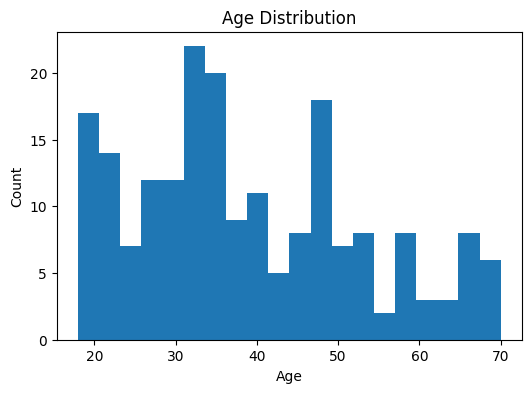

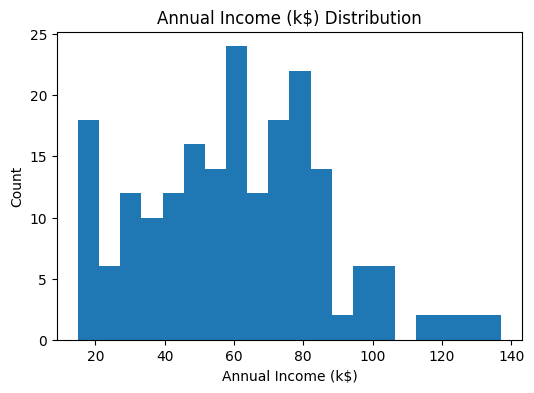

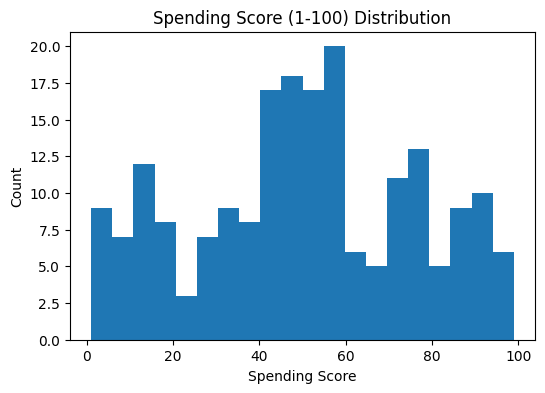

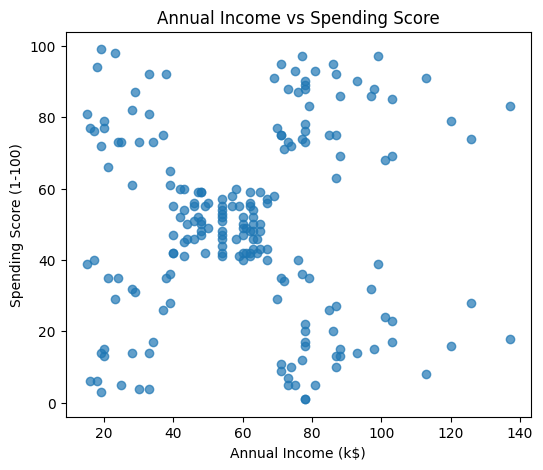

In [5]:
# Histograms
plt.figure(figsize=(6,4))
plt.hist(df['Age'], bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['Annual Income (k$)'], bins=20)
plt.title('Annual Income (k$) Distribution')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['Spending Score (1-100)'], bins=20)
plt.title('Spending Score (1-100) Distribution')
plt.xlabel('Spending Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Annual Income vs Spending Score')
plt.show()

## Preprocessing and Clustering
Using `Age`, `Annual Income (k$)`, and `Spending Score (1-100)` for clustering. We will standardize features and evaluate k from 2 to 10 using inertia and silhouette score.

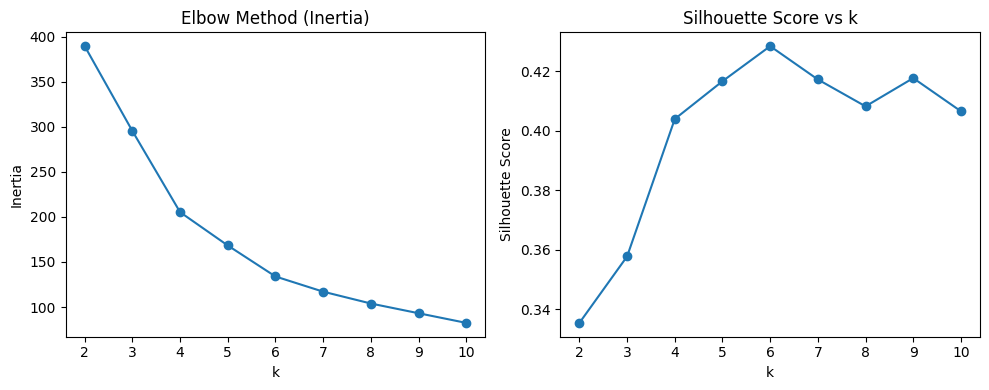

Chosen number of clusters by silhouette: 6


In [6]:
# Prepare features
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine best k
K_range = range(2,11)
inertia = []
silhouette = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method (Inertia)')

plt.subplot(1,2,2)
plt.plot(list(K_range), silhouette, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

best_k = list(K_range)[int(np.argmax(silhouette))]
print('Chosen number of clusters by silhouette:', best_k)


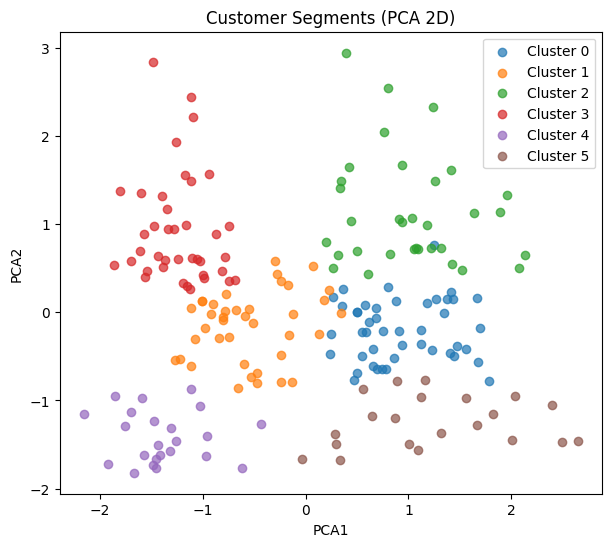

In [7]:
# Final KMeans fit
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(7,6))
for cl in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster']==cl]
    plt.scatter(subset['PCA1'], subset['PCA2'], alpha=0.7, label=f'Cluster {cl}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segments (PCA 2D)')
plt.legend()
plt.show()

In [8]:
# Cluster profiling
profile = df.groupby('Cluster')[features].agg(['mean','median','count']).round(2)
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df.index.name = 'Cluster'

print('Cluster profile (means/median/count):')
display(profile)
print('\nCentroids (original scale):')
display(centroids_df)

# Simple strategy suggestions
def suggest_strategy(row):
    age = row['Age']
    income = row['Annual Income (k$)']
    spend = row['Spending Score (1-100)']
    if (income >= 70) and (spend >= 60):
        return 'High income & high spenders: Premium loyalty program, exclusive offers.'
    elif (income >= 70) and (spend < 60):
        return 'High income & low spenders: Personalized engagement to increase frequency.'
    elif (income < 40) and (spend >= 60):
        return 'Low income & high spenders: Frequent small-ticket promotions, referral incentives.'
    elif (income < 40) and (spend < 40):
        return 'Low income & low spenders: Discount and value-focused campaigns.'
    else:
        return 'Mid income / mixed: Cross-sell and seasonal promotions.'

strategies = centroids_df.copy()
strategies['Suggested Strategy'] = strategies.apply(suggest_strategy, axis=1)
print('\nSuggested strategies per cluster:')
display(strategies)


Cluster profile (means/median/count):


Age              Annual Income (k$)              Spending Score (1-100)             
          mean median count               mean median count                   mean median count
Cluster                                                                                        
0        56.33   54.0    45              54.27   54.0    45                  49.07   49.0    45
1        26.79   26.0    39              57.10   60.0    39                  48.13   50.0    39
2        41.94   43.0    33              88.94   86.0    33                  16.97   16.0    33
3        32.69   32.0    39              86.54   79.0    39                  82.13   83.0    39
4        25.00   23.0    23              25.26   24.0    23                  77.61   77.0    23
5        45.52   46.0    21              26.29   25.0    21                  19.38   15.0    21


Centroids (original scale):


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,56.333333,54.266667,49.066667
1,26.794872,57.102564,48.128205
2,41.939394,88.939394,16.969697
3,32.692308,86.538462,82.128205
4,25.000000,25.260870,77.608696
5,45.523810,26.285714,19.380952



Suggested strategies per cluster:


,Age,Annual Income (k$),Spending Score (1-100),Suggested Strategy
Cluster,,,,
0,56.333333,54.266667,49.066667,Mid income / mixed: Cross-sell and seasonal pr...
1,26.794872,57.102564,48.128205,Mid income / mixed: Cross-sell and seasonal pr...
2,41.939394,88.939394,16.969697,High income & low spenders: Personalized engag...
3,32.692308,86.538462,82.128205,High income & high spenders: Premium loyalty p...
4,25.000000,25.260870,77.608696,Low income & high spenders: Frequent small-tic...
5,45.523810,26.285714,19.380952,Low income & low spenders: Discount and value-...


In [10]:
# Save segmented dataset
out_path = "Mall_Customers.csv"
df.to_csv(out_path, index=False)
print('Segmented CSV saved to', out_path)

# Save notebook path message
print('Notebook ready. Run all cells to reproduce analysis and outputs.')

Segmented CSV saved to Mall_Customers.csv
Notebook ready. Run all cells to reproduce analysis and outputs.
